In [62]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply
from keras.models import Model
# from attention_utils import get_activations
from keras.layers.core import *
from keras.layers import LSTM
from keras.models import *
import numpy as np
import xgboost as xgb
import keras.backend as K 
from keras.utils.vis_utils import plot_model

In [63]:
def NormalizeMult(data):
    data = np.array(data)
    normalize = np.arange(2*data.shape[1], dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0, data.shape[1]):
        list = data[:, i]
        listlow, listhigh = np.percentile(list, [0, 100])
        # print(i)
        normalize[i, 0] = listlow
        normalize[i, 1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - listlow)/delta
    # np.save("./normalize.npy",normalize)
    return data, normalize

In [64]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

In [65]:
def attention_3d_block(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [66]:
def attention_model(INPUT_DIMS = 13,TIME_STEPS = 20,lstm_units = 64):
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)  # padding = 'same'
    x = Dropout(0.3)(x)

    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [67]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [68]:
def prepare_data(series, n_test, n_in, n_out):
    values = series.values
    supervised_data = series_to_supervised(values, n_in, n_out)
    print('supervised_data', supervised_data)
    train, test = supervised_data.loc[:3500, :], supervised_data.loc[3501:, :]
    return train, test

In [69]:
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # print('train', train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # print('trainX', trainX, 'trainy', trainy)
    # fit model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

In [70]:
def walk_forward_validation(train, test):
    predictions = list()
    train = train.values
    history = [x for x in train]
    # print('history', history)
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        # print('i', i, testX, testy)
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i, :])
        print(i+1, '>expected=%.6f, predicted=%.6f' % (testy, yhat))
    return test.iloc[:, -1],predictions

In [71]:
def xgb_scheduler(data,y_hat):
    close = data.pop('Close')
    data.insert(4, 'Close', close)
    train, test = prepare_data(data, n_test=len(y_hat), n_in=6, n_out=1)
    testY, y_hat2 = walk_forward_validation(train, test)
    return testY, y_hat2


In [72]:
def PredictWithData(data,data_yuan,name,modelname,INPUT_DIMS = 13,TIME_STEPS = 20):
    print(data.columns)
    yindex = data.columns.get_loc(name)
    print(yindex)
    data = np.array(data, dtype='float64')
    data, normalize = NormalizeMult(data)
    data_y = data[:, yindex]
    data_y = data_y.reshape(data_y.shape[0], 1)

    testX, _ = create_dataset(data)
    _, testY = create_dataset(data_y)
    print("testX Y shape is:", testX.shape, testY.shape)
    if len(testY.shape) == 1:
        testY = testY.reshape(-1, 1)

    model = attention_model(INPUT_DIMS)
    model.load_weights(modelname)
    model.summary()
    y_hat =  model.predict(testX)
    testY, y_hat = xgb_scheduler(data_yuan, y_hat)
    return y_hat, testY

In [73]:
def evaluation_metric(y_test,y_hat):
    MSE = metrics.mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = metrics.mean_absolute_error(y_test,y_hat)
    R2 = metrics.r2_score(y_test,y_hat)
    print('MSE: %.5f' % MSE)
    print('RMSE: %.5f' % RMSE)
    print('MAE: %.5f' % MAE)
    print('R2: %.5f' % R2)

In [74]:
data1 = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\TCS.csv")
data1.index = pd.to_datetime(data1['Date'], format='%Y-%m-%d')
#data1 = data1.drop(['ts_code', 'trade_date', 'turnover_rate', 'volume_ratio', 'pb', 'total_share', 'float_share', 'free_share'], axis=1)
data1 = data1.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]
data_yuan = data1.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]
residuals = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\ARIMA_residuals1.csv")
residuals.index = pd.to_datetime(residuals['Date'])
residuals.pop('Date')
data1 = pd.merge(data1, residuals, on='Date')
data = data1.iloc[1:3500, :] 
data2 = data1.iloc[3500:, :] 


In [82]:
data1.head()

,Open,High,Low,Close,Volume,Residuals
Date,,,,,,
2008-04-29,220.512497,232.5000,217.537506,227.637497,16209848,227.637497
2008-04-30,229.024994,233.9375,226.625000,230.250000,9487980,2.614066
2008-05-02,231.250000,240.5000,231.000000,235.937500,5298780,5.718868
2008-05-05,236.250000,237.3750,230.287506,231.862503,3613764,-3.921495
2008-05-06,227.500000,237.5000,218.149994,234.262497,3982796,2.567787


In [75]:
TIME_STEPS = 20

In [76]:
data, normalize = NormalizeMult(data)
print('#', normalize)
pollution_data = data[:, 3].reshape(len(data), 1)

(6, 2)
# [[ 1.12000000e+02  4.03394995e+03]
 [ 1.16112503e+02  4.04300000e+03]
 [ 1.03837502e+02  3.98000000e+03]
 [ 1.11550003e+02  4.01914990e+03]
 [ 0.00000000e+00  8.80671540e+07]
 [-2.46604409e+02  1.82808352e+02]]


In [77]:
train_X, _ = create_dataset(data, TIME_STEPS)
_, train_Y = create_dataset(pollution_data, TIME_STEPS)

print(train_X.shape, train_Y.shape)

(3478, 20, 6) (3478, 1)


In [78]:
m = attention_model(INPUT_DIMS=6)
m.summary() 
print(len(m.layers))
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse') 
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.1)
m.save("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Codes\stock_model.h5")
np.save("stock_normalize.npy", normalize)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 20, 6)]      0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 20, 64)       448         ['input_8[0][0]']                
                                                                                                  
 dropout_14 (Dropout)           (None, 20, 64)       0           ['conv1d_7[0][0]']               
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 20, 128)     66048       ['dropout_14[0][0]']             
 )                                                                                          

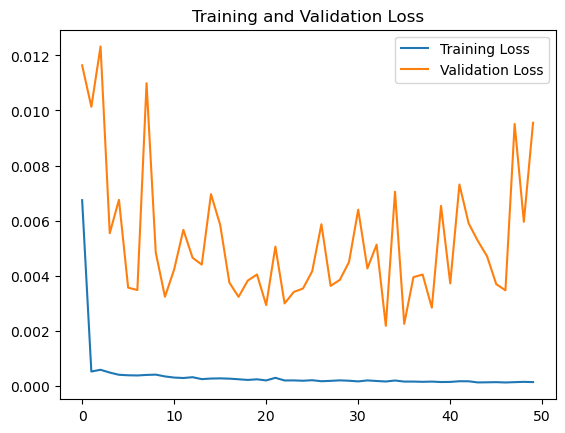

In [79]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [80]:
class Config:
    def __init__(self):
        self.dimname = 'Close'

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Residuals'], dtype='object')
3
(6, 2)
testX Y shape is: (160, 20, 6) (160, 1)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 20, 6)]      0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 20, 64)       448         ['input_9[0][0]']                
                                                                                                  
 dropout_16 (Dropout)           (None, 20, 64)       0           ['conv1d_8[0][0]']               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 20, 128)     66048     

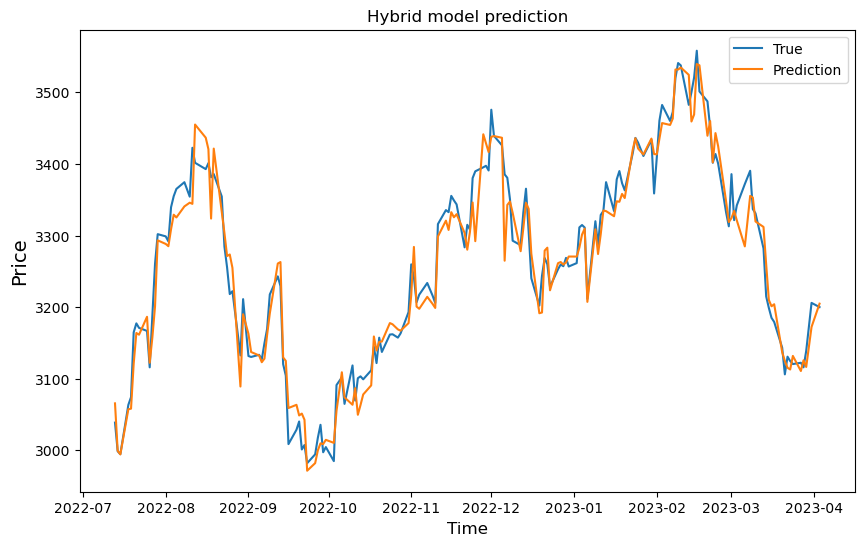

In [81]:
config = Config()
name = config.dimname
# normalize = np.load("normalize.npy")
y_hat, y_test = PredictWithData(data2, data_yuan, name, 'stock_model.h5',6)
y_hat = np.array(y_hat, dtype='float64')
y_test = np.array(y_test, dtype='float64')
evaluation_metric(y_test,y_hat)
time = pd.Series(data1.index[3501:])
plt.figure(figsize=(10, 6))
plt.plot(time, y_test, label='True')
plt.plot(time, y_hat, label='Prediction')
plt.title('Hybrid model prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Price', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()